In [1]:
# Standard Data Packages
import pandas as pd
import numpy as np

# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

# tf and keras
import tensorflow as tf
from keras import models
from keras import layers

from sklearn import metrics

In [2]:
train_set = pd.read_csv("train_set.csv")
val_set = pd.read_csv("val_set.csv")

In [3]:
features = ["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]

X_train = train_set[features]
Y_train = train_set["Exited"]

X_val = val_set[features]
Y_val = val_set["Exited"]

In [4]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,685,france,female,39.0,2,0.00,2,1.0,1.0,155870.82
1,659,spain,male,72.0,4,138292.64,1,1.0,1.0,83629.60
2,584,france,female,40.0,5,0.00,1,1.0,0.0,113581.71
3,578,germany,male,29.0,6,143688.47,2,1.0,0.0,140137.73
4,745,france,male,36.0,9,0.00,1,1.0,1.0,107876.20


In [5]:
X_train.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object

In [6]:
display(X_train.max(axis=0))
display(X_train.min(axis=0))

CreditScore              850
Geography              spain
Gender                  male
Age                     92.0
Tenure                    10
Balance            250898.09
NumOfProducts              4
HasCrCard                1.0
IsActiveMember           1.0
EstimatedSalary    199992.48
dtype: object

CreditScore           350
Geography          france
Gender             female
Age                  18.0
Tenure                  0
Balance               0.0
NumOfProducts           1
HasCrCard             0.0
IsActiveMember        0.0
EstimatedSalary     11.58
dtype: object

In [7]:
def build_model1(learning_rate=0.01):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    input = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "CreditScore")

    input_bins = np.arange(85, 851, 85)
    
    #bucket age into corresponding bucket
    input_binned = tf.keras.layers.Discretization(bin_boundaries = input_bins)(input)
    
    #create one-hot encoding for age buckets
    input_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(input_bins) + 1),
        output_mode = "one_hot")(input_binned)


    #add dense layer 1
    hidden1 = tf.keras.layers.Dense(units = 32, activation = "relu", name = "hidden1")(input_id)
    
    #add dense layer 2
    hidden2 = tf.keras.layers.Dense(units = 24, activation = "relu", name = "hidden2")(hidden1)

    #add output layer
    dx = tf.keras.layers.Dense(units = 1, activation = "sigmoid", name = "Dx")(hidden2)
    
    #configure model
    model = tf.keras.Model(inputs = input, outputs = dx, name = "model1")
    
    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CreditScore (InputLayer)    [(None, 1)]               0         
                                                                 
 discretization (Discretizat  (None, 1)                0         
 ion)                                                            
                                                                 
 integer_lookup (IntegerLook  (None, 12)               0         
 up)                                                             
                                                                 
 hidden1 (Dense)             (None, 32)                416       
                                                                 
 hidden2 (Dense)             (None, 24)                792       
                                                                 
 Dx (Dense)                  (None, 1)                 25   

2024-07-16 15:19:42.581967: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


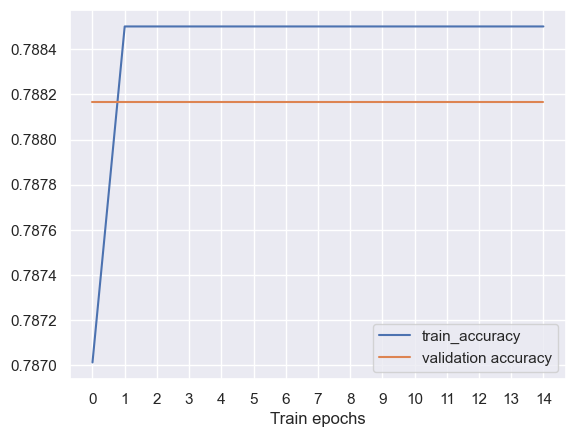

,loss,accuracy,val_loss,val_accuracy
0,0.522598,0.787012,0.516162,0.788168
1,0.515697,0.788501,0.516074,0.788168
2,0.515604,0.788501,0.515971,0.788168
3,0.515528,0.788501,0.515994,0.788168
4,0.515517,0.788501,0.516018,0.788168
5,0.515487,0.788501,0.515969,0.788168
6,0.515504,0.788501,0.515964,0.788168
7,0.515482,0.788501,0.515947,0.788168
8,0.515499,0.788501,0.515961,0.788168
9,0.515488,0.788501,0.515974,0.788168


In [8]:
num_epochs = 15

model1 = build_model1(0.01)
model1.summary()

history = model1.fit(
    x = X_train[["CreditScore"]],
    y = Y_train,
    epochs = num_epochs,
    batch_size = 32,
    validation_data = (
        X_val[["CreditScore"]],
        Y_val),
    verbose = 0)

train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.xticks(range(num_epochs))
plt.xlabel("Train epochs")
plt.legend()
plt.show()

history = pd.DataFrame(history.history)
display(history)

In [9]:
def build_model2(optimizer = "SGD", learning_rate = 0.01):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    credit_score = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "CreditScore")
    credit_score_bins = np.arange((X_train.CreditScore.max(axis = 0) / 10), (X_train.CreditScore.max(axis = 0) + 1), (X_train.CreditScore.max(axis = 0) / 10))
    credit_score_binned = tf.keras.layers.Discretization(bin_boundaries = credit_score_bins)(credit_score)
    credit_score_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(credit_score_bins) + 1),
        output_mode = "one_hot")(credit_score_binned)

    geography = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = "Geography")
    geography_id = tf.keras.layers.StringLookup(vocabulary = ["spain", "france", "germany"], output_mode = "one_hot")(geography)
    
    gender = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = "Gender")
    gender_id = tf.keras.layers.StringLookup(vocabulary = ["male", "female"], output_mode = "one_hot")(gender)
 
    age = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Age")
    age_bins = np.arange((X_train.Age.max(axis = 0) / 10), (X_train.Age.max(axis = 0) + 1), (X_train.Age.max(axis = 0) / 10))
    age_binned = tf.keras.layers.Discretization(bin_boundaries = age_bins)(age)
    age_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(age_bins) + 1),
        output_mode = "one_hot")(age_binned)
    
    tenure = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Tenure")
    tenure_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, (X_train.Tenure.max(axis = 0) + 1)),
        output_mode = "one_hot")(tenure)
    
    balance = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Balance")
    balance_bins = np.arange((X_train.Balance.max(axis = 0) / 10), (X_train.Balance.max(axis = 0) + 1), (X_train.Balance.max(axis = 0) / 10))
    balance_binned = tf.keras.layers.Discretization(bin_boundaries = balance_bins)(balance)
    balance_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(balance_bins) + 1),
        output_mode = "one_hot")(balance_binned)
    
    numProducts = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "NumOfProducts")
    numProducts_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, (X_train.NumOfProducts.max(axis = 0) + 1)),
        output_mode = "one_hot")(numProducts)
    
    crCard = tf.keras.layers.Input(shape = (1, ), dtype = tf.int64, name = "HasCrCard")
    crCard_id = tf.keras.layers.IntegerLookup(
        vocabulary = [0, 1],
        output_mode = "one_hot")(crCard)
    
    activeMember = tf.keras.layers.Input(shape = (1, ), dtype = tf.int64, name = "IsActiveMember")
    activeMember_id = tf.keras.layers.IntegerLookup(
        vocabulary = [0, 1],
        output_mode = "one_hot")(activeMember)
    
    salary = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "EstimatedSalary")
    salary_bins = np.arange((X_train.EstimatedSalary.max(axis = 0) / 10), (X_train.EstimatedSalary.max(axis = 0) + 1), (X_train.EstimatedSalary.max(axis = 0) / 10))
    salary_binned = tf.keras.layers.Discretization(bin_boundaries = salary_bins)(salary)
    salary_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(salary_bins) + 1),
        output_mode = "one_hot")(salary_binned)

    features = tf.keras.layers.Concatenate()([credit_score_id, geography_id, gender_id, age_id, tenure_id, balance_id, numProducts_id, crCard_id, activeMember_id, salary_id])

    #add dense layer 1
    hidden1 = tf.keras.layers.Dense(units = 32, activation = "relu", name = "hidden1")(features)
    
    #add dense layer 2
    hidden2 = tf.keras.layers.Dense(units = 24, activation = "relu", name = "hidden2")(hidden1)

    #add dense layer 3
    hidden3 = tf.keras.layers.Dense(units = 12, activation = "relu", name = "hidden3")(hidden2)

    #add output layer
    dx = tf.keras.layers.Dense(units = 1, activation = "sigmoid", name = "Dx")(hidden3)
    
    #configure model
    model = tf.keras.Model(inputs = [credit_score, geography, gender, age, tenure, balance, numProducts, crCard, activeMember, salary], outputs = dx, name = "model2")

    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == "Adam": #for testing
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CreditScore (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Balance (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 EstimatedSalary (InputLayer)   [(None, 1)]          0           []                               
                                                                                             

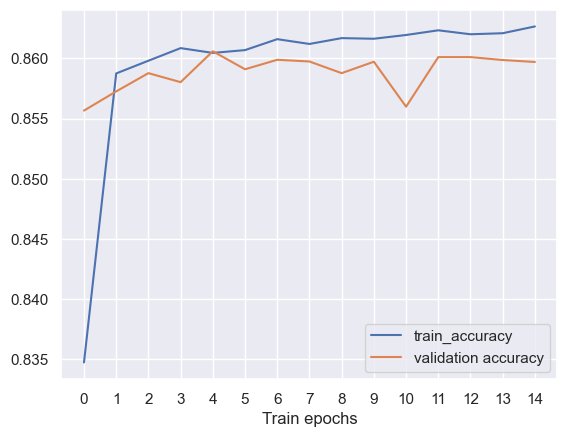

,loss,accuracy,val_loss,val_accuracy
0,0.378800,0.834743,0.341620,0.855668
1,0.336753,0.858755,0.338621,0.857264
2,0.333912,0.859811,0.337025,0.858779
3,0.332261,0.860859,0.334687,0.858032
4,0.331128,0.860461,0.333440,0.860597
5,0.330150,0.860694,0.333487,0.859102
6,0.329467,0.861603,0.332654,0.859890
7,0.328777,0.861205,0.332130,0.859748
8,0.328274,0.861690,0.332551,0.858779
9,0.327945,0.861638,0.331092,0.859728


In [10]:
model2 = build_model2(learning_rate = 0.01)
model2.summary()

history = model2.fit(
    x = {
        "CreditScore": X_train[["CreditScore"]],
        "Geography": X_train[["Geography"]],
        "Gender": X_train[["Gender"]],
        "Age": X_train[["Age"]],
        "Tenure": X_train[["Tenure"]],
        "Balance": X_train[["Balance"]],
        "NumOfProducts": X_train[["NumOfProducts"]],
        "HasCrCard": X_train[["HasCrCard"]],
        "IsActiveMember": X_train[["IsActiveMember"]],
        "EstimatedSalary": X_train[["EstimatedSalary"]],
    },
    y = Y_train,
    epochs = num_epochs,
    batch_size = 32,
    validation_data = (
        {
            "CreditScore": X_val[["CreditScore"]],
            "Geography": X_val[["Geography"]],
            "Gender": X_val[["Gender"]],
            "Age": X_val[["Age"]],
            "Tenure": X_val[["Tenure"]],
            "Balance": X_val[["Balance"]],
            "NumOfProducts": X_val[["NumOfProducts"]],
            "HasCrCard": X_val[["HasCrCard"]],
            "IsActiveMember": X_val[["IsActiveMember"]],
            "EstimatedSalary": X_val[["EstimatedSalary"]],
        },
        Y_val),
    verbose = 0)

train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.xticks(range(num_epochs))
plt.xlabel("Train epochs")
plt.legend()
plt.show()

history = pd.DataFrame(history.history)
display(history)

In [11]:
def build_model3(optimizer = "SGD", learning_rate = 0.01):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    credit_score = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "CreditScore")
    credit_score_bins = np.arange((X_train.CreditScore.max(axis = 0) / 10), (X_train.CreditScore.max(axis = 0) + 1), (X_train.CreditScore.max(axis = 0) / 10))
    credit_score_binned = tf.keras.layers.Discretization(bin_boundaries = credit_score_bins)(credit_score)
    credit_score_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(credit_score_bins) + 1),
        output_mode = "one_hot")(credit_score_binned)

    geography = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = "Geography")
    geography_id = tf.keras.layers.StringLookup(vocabulary = ["spain", "france", "germany"], output_mode = "one_hot")(geography)
    
    gender = tf.keras.layers.Input(shape = (1, ), dtype = tf.string, name = "Gender")
    gender_id = tf.keras.layers.StringLookup(vocabulary = ["male", "female"], output_mode = "one_hot")(gender)
 
    age = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Age")
    age_bins = np.arange((X_train.Age.max(axis = 0) / 10), (X_train.Age.max(axis = 0) + 1), (X_train.Age.max(axis = 0) / 10))
    age_binned = tf.keras.layers.Discretization(bin_boundaries = age_bins)(age)
    age_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(age_bins) + 1),
        output_mode = "one_hot")(age_binned)
    
    tenure = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Tenure")
    tenure_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, (X_train.Tenure.max(axis = 0) + 1)),
        output_mode = "one_hot")(tenure)
    
    balance = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Balance")
    balance_bins = np.arange((X_train.Balance.max(axis = 0) / 10), (X_train.Balance.max(axis = 0) + 1), (X_train.Balance.max(axis = 0) / 10))
    balance_binned = tf.keras.layers.Discretization(bin_boundaries = balance_bins)(balance)
    balance_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(balance_bins) + 1),
        output_mode = "one_hot")(balance_binned)
    
    numProducts = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "NumOfProducts")
    numProducts_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, (X_train.NumOfProducts.max(axis = 0) + 1)),
        output_mode = "one_hot")(numProducts)

    crCard = tf.keras.layers.Input(shape = (1, ), dtype = tf.int64, name = "HasCrCard")
    crCard_id = tf.keras.layers.IntegerLookup(
        vocabulary = [0, 1],
        output_mode = "one_hot")(crCard)
    
    activeMember = tf.keras.layers.Input(shape = (1, ), dtype = tf.int64, name = "IsActiveMember")
    activeMember_id = tf.keras.layers.IntegerLookup(
        vocabulary = [0, 1],
        output_mode = "one_hot")(activeMember)
    
    salary = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "EstimatedSalary")
    salary_bins = np.arange((X_train.EstimatedSalary.max(axis = 0) / 10), (X_train.EstimatedSalary.max(axis = 0) + 1), (X_train.EstimatedSalary.max(axis = 0) / 10))
    salary_binned = tf.keras.layers.Discretization(bin_boundaries = salary_bins)(salary)
    salary_id = tf.keras.layers.IntegerLookup(
        vocabulary = np.arange(0, len(salary_bins) + 1),
        output_mode = "one_hot")(salary_binned)

    features = tf.keras.layers.Concatenate()([credit_score_id, geography_id, gender_id, age_id, tenure_id, balance_id, numProducts_id, crCard_id, activeMember_id, salary_id])


    #add dense layer 1
    hidden1 = tf.keras.layers.Dense(units = 64, activation = "relu", name = "hidden1")(features)

    #add dense layer 2
    hidden2 = tf.keras.layers.Dense(units = 128, activation = "relu", name = "hidden2")(hidden1)

    #add dense layer 3
    hidden3 = tf.keras.layers.Dense(units = 254, activation = "relu", name = "hidden4")(hidden2)

    #add dense layer 5
    hidden4 = tf.keras.layers.Dense(units = 32, activation = "relu", name = "hidden5")(hidden3)

    #add output layer
    dx = tf.keras.layers.Dense(units = 1, activation = "sigmoid", name = "Dx")(hidden4)
    
    #configure model
    model = tf.keras.Model(inputs = [credit_score, geography, gender, age, tenure, balance, numProducts, crCard, activeMember, salary], outputs = dx, name = "model2")

    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == "Adam": #for testing
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CreditScore (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Balance (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 EstimatedSalary (InputLayer)   [(None, 1)]          0           []                               
                                                                                             

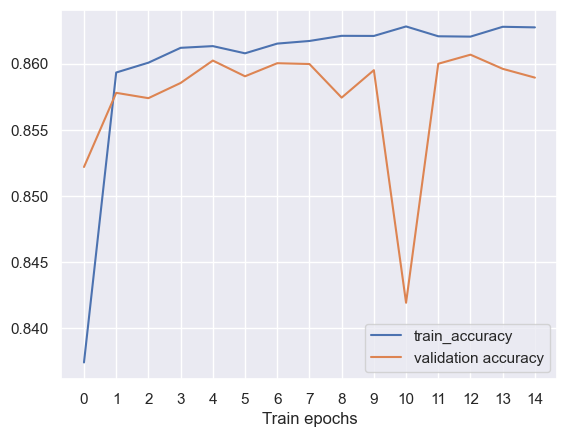

,loss,accuracy,val_loss,val_accuracy
0,0.373745,0.837374,0.345663,0.852174
1,0.334356,0.859327,0.336630,0.857789
2,0.331740,0.860071,0.338533,0.857385
3,0.330231,0.861196,0.333414,0.858536
4,0.329193,0.861326,0.332536,0.860233
5,0.328248,0.860781,0.334482,0.859041
6,0.327627,0.861517,0.331325,0.860031
7,0.326845,0.861716,0.331334,0.859971
8,0.326332,0.862105,0.333184,0.857426
9,0.326101,0.862097,0.330719,0.859506


In [12]:
model3 = build_model3(learning_rate = 0.01)
model3.summary()

history = model3.fit(
    x = {
        "CreditScore": X_train[["CreditScore"]],
        "Geography": X_train[["Geography"]],
        "Gender": X_train[["Gender"]],
        "Age": X_train[["Age"]],
        "Tenure": X_train[["Tenure"]],
        "Balance": X_train[["Balance"]],
        "NumOfProducts": X_train[["NumOfProducts"]],
        "HasCrCard": X_train[["HasCrCard"]],
        "IsActiveMember": X_train[["IsActiveMember"]],
        "EstimatedSalary": X_train[["EstimatedSalary"]],
    },
    y = Y_train,
    epochs = num_epochs,
    batch_size = 32,
    validation_data = (
        {
            "CreditScore": X_val[["CreditScore"]],
            "Geography": X_val[["Geography"]],
            "Gender": X_val[["Gender"]],
            "Age": X_val[["Age"]],
            "Tenure": X_val[["Tenure"]],
            "Balance": X_val[["Balance"]],
            "NumOfProducts": X_val[["NumOfProducts"]],
            "HasCrCard": X_val[["HasCrCard"]],
            "IsActiveMember": X_val[["IsActiveMember"]],
            "EstimatedSalary": X_val[["EstimatedSalary"]],
        },
        Y_val),
    verbose = 0)

train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.xticks(range(num_epochs))
plt.xlabel("Train epochs")
plt.legend()
plt.show()

history = pd.DataFrame(history.history)
display(history)

1548/1548 [==============================] - 1s 396us/step
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     39023
           1       0.76      0.49      0.59     10488

    accuracy                           0.86     49511
   macro avg       0.82      0.72      0.75     49511
weighted avg       0.85      0.86      0.85     49511



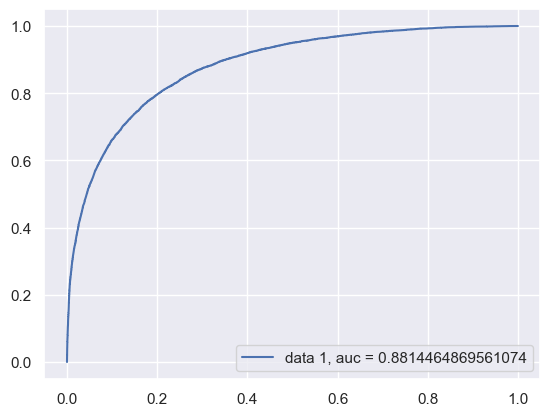

In [13]:
predict_val = model3.predict({
            "CreditScore": X_val[["CreditScore"]],
            "Geography": X_val[["Geography"]],
            "Gender": X_val[["Gender"]],
            "Age": X_val[["Age"]],
            "Tenure": X_val[["Tenure"]],
            "Balance": X_val[["Balance"]],
            "NumOfProducts": X_val[["NumOfProducts"]],
            "HasCrCard": X_val[["HasCrCard"]],
            "IsActiveMember": X_val[["IsActiveMember"]],
            "EstimatedSalary": X_val[["EstimatedSalary"]],
        })

fpr, tpr, _ = metrics.roc_curve(Y_val, predict_val)
auc = metrics.roc_auc_score(Y_val, predict_val)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

predict_val[predict_val <= 0.5] = 0
predict_val[predict_val > 0.5] = 1

print(metrics.classification_report(Y_val, predict_val))

plt.show()

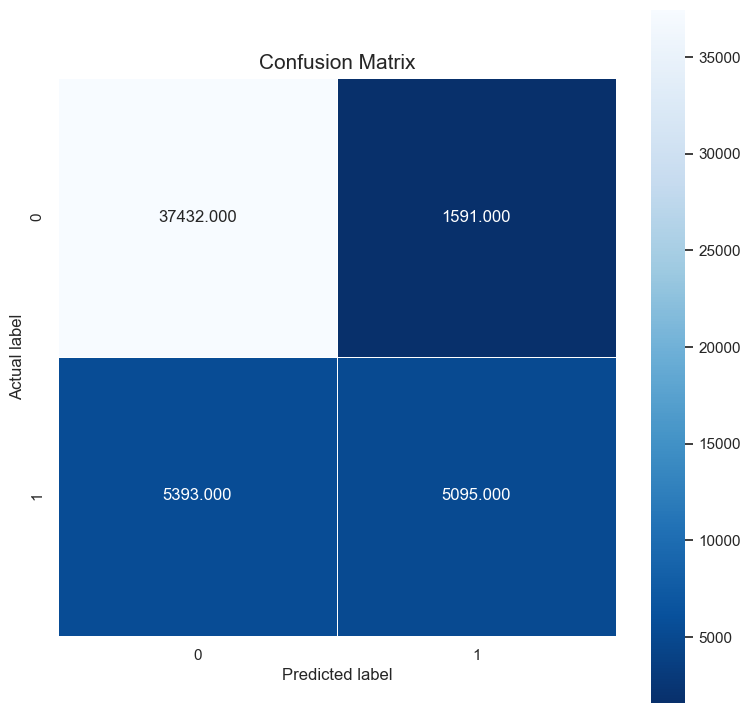

In [14]:
confusion_matrix = metrics.confusion_matrix(Y_val, predict_val)

plt.figure(figsize=(9,9))
sns.heatmap(confusion_matrix, annot=True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

In [15]:
model3.save("MNN_discret.keras")